# Курсовая работа по курсу "Технологии машинного обучения"

В качестве набора данных будем использовать датасет о погоде в Австралии - https://www.kaggle.com/jsphyg/weather-dataset-rattle-package. Он содержит около 10 лет ежедневных наблюдений за погодой из многих мест по всей Австралии. 

На его основе можно обучить модели классификации на целевой переменной RainTomorrow и прогнозировать дождь на следующий день. 

Файл содержит следующие колонки:
- Date - дата наблюдения;
- Location - общепринятое название местоположения метеостанции;
- MinTemp - минимальная температура в градусах Цельсия;
- MaxTemp - максимальная температура в градусах Цельсия;
- Rainfall - количество осадков, зафиксированных за день в мм;
- Evaporation - испарение класса А (мм) за 24 часа до 9 утра;
- Sunshine - количество часов яркого солнечного света в день;
- WindGustDir - направление сильнейшего порыва ветра за 24 часа до полуночи;
- WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за 24 часа до полуночи;
- WindDir9am - направление ветра в 9 часов утра;
- WindDir3pm - направление ветра в 3 часа дня;
- WindSpeed9am - средняя скорость ветра (км / ч) за 10 минут до 9 часов утра;
- WindSpeed3pm - средняя скорость ветра (км / ч) за 10 минут до 3 часов дня;
- Humidity9am - влажность (в процентах) в 9 утра;
- Humidity3pm - влажность (в процентах) в 3 дня;
- Pressure9am - атмосферное давление (гПа) снижено до среднего уровня моря в 9 утра;
- Pressure3pm - атмосферное давление (гПа) снижено до среднего уровня моря в 3 дня;
- Cloud9am - облачность (часть неба, закрытая облаками) в 9 утра;
- Cloud3pm - облачность в 3 дня;
- Temp9am - температура в градусах Цельсия в 9 утра;
- Temp3pm - температура в градусах Цельсия в 3 дня;
- RainToday - Да, если количество осадков (мм) за 24 часа до 9 утра превышает 1 мм, в противном случае - Нет;
- RainTomorrow - количество осадков на следующий день в мм. Своеобразная мера «риска».

Т.к. целевая переменная содержит только два значения (да или нет), то будем решать задачу бинарной классификации.

### Импорт библиотек

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from supervised.automl import AutoML

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

### Загрузка данных

In [6]:
# Файл в формате csv, поэтому разделитель - запятая
data = pd.read_csv('weatherAUS.csv', sep=",")

### Основные характеристики датасета

In [7]:
# Размер набора данных
data.shape

(145460, 23)

In [8]:
# Типы колонок
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [9]:
# Проверим есть ли пропущенные значения
data.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [10]:
# Первые 5 строк датасета
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [11]:
total_count = data.shape[0]
print("Всего строк: {}".format(total_count))

Всего строк: 145460


### Обработка пропусков в числовых данных

Для создания эффективной модели прогнозирования удалим признаки, в которых пропуски составляют 30% от всех данных или больше.

In [12]:
num_cols = [] # массив числовых признаков с пустыми значениями
cols_to_del = [] # массив числовых признаков на удаление
for col in data.columns:
    count_null = data[data[col].isnull()].shape[0] # кол-во пустых значений
    dt = str(data[col].dtypes)
    if count_null>0 and ((dt == 'int64') or (dt == 'float64')): # проверка на пропуски в числовых значениях
        num_cols.append(col)
        perc_of_missing = round(count_null/total_count * 100, 2)
        if perc_of_missing > 30: # если пропусков больше 30%, то удаляем признак
            cols_to_del.append(col)
        print("Колонка: {}. Тип данных: {}. Количество пустых значений: {}, {}%".format(col, dt, count_null, perc_of_missing))
print(cols_to_del)

Колонка: MinTemp. Тип данных: float64. Количество пустых значений: 1485, 1.02%
Колонка: MaxTemp. Тип данных: float64. Количество пустых значений: 1261, 0.87%
Колонка: Rainfall. Тип данных: float64. Количество пустых значений: 3261, 2.24%
Колонка: Evaporation. Тип данных: float64. Количество пустых значений: 62790, 43.17%
Колонка: Sunshine. Тип данных: float64. Количество пустых значений: 69835, 48.01%
Колонка: WindGustSpeed. Тип данных: float64. Количество пустых значений: 10263, 7.06%
Колонка: WindSpeed9am. Тип данных: float64. Количество пустых значений: 1767, 1.21%
Колонка: WindSpeed3pm. Тип данных: float64. Количество пустых значений: 3062, 2.11%
Колонка: Humidity9am. Тип данных: float64. Количество пустых значений: 2654, 1.82%
Колонка: Humidity3pm. Тип данных: float64. Количество пустых значений: 4507, 3.1%
Колонка: Pressure9am. Тип данных: float64. Количество пустых значений: 15065, 10.36%
Колонка: Pressure3pm. Тип данных: float64. Количество пустых значений: 15028, 10.33%
Колонк

In [13]:
# Удаляем неподходящие признаки
data.drop(cols_to_del, inplace=True, axis=1)
data.shape

(145460, 19)

In [14]:
# Оставшиеся признаки с пустыми значениями
cols_left = [x for x in num_cols if not any(x in y for y in cols_to_del)]
cols_left

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [15]:
left_data = data[cols_left]
left_data

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,23.4,0.0,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4
145456,3.6,25.3,0.0,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5
145457,5.4,26.9,0.0,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1
145458,7.8,27.0,0.0,28.0,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0


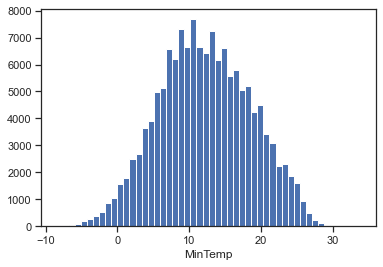

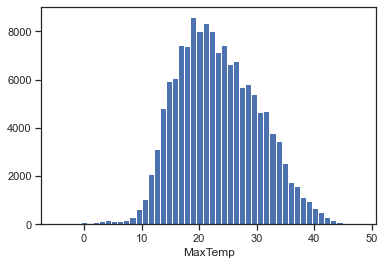

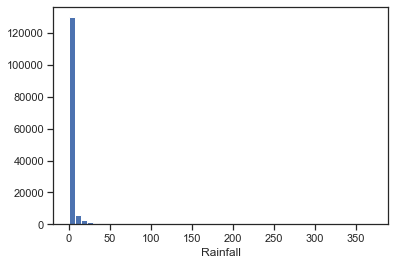

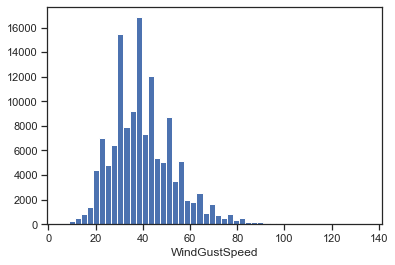

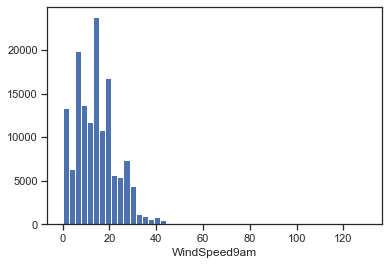

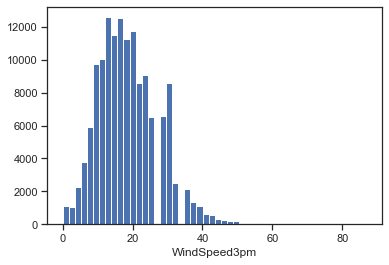

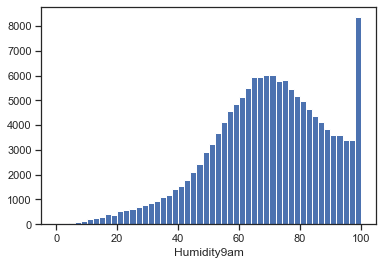

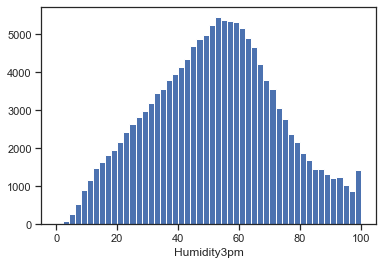

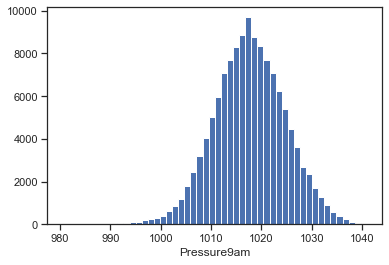

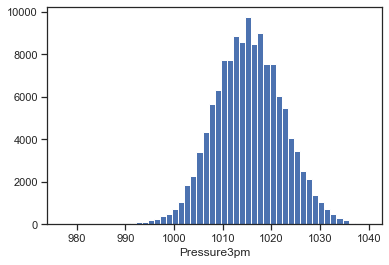

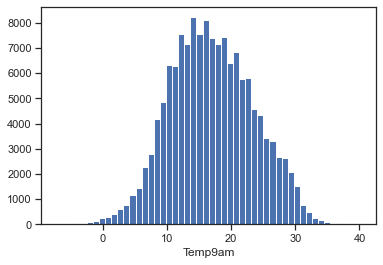

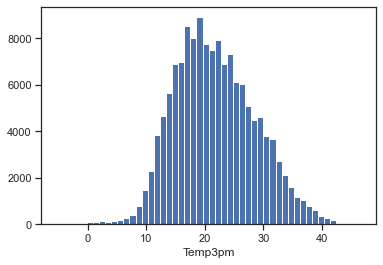

In [16]:
# Гистограмма по признакам
for col in left_data:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [17]:
# Функция, которая для заданной колонки делает импьютацию по заданной стратегии
def test_num_impute_col(dataset, column, strat_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strat_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    dataset[column] = dataset[column].fillna(filled_data[0])
    
    return filled_data[0]

In [18]:
# Заполнение пропусков по моде
mf = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am',
      'WindSpeed3pm','Pressure9am','Pressure3pm','Temp9am','Temp3pm']
for i in mf:
    b = test_num_impute_col(data, i, 'most_frequent')
    print("Пропуски в колонке {} заполнены значением {}".format(i, b))

Пропуски в колонке MinTemp заполнены значением 11.0
Пропуски в колонке MaxTemp заполнены значением 20.0
Пропуски в колонке Rainfall заполнены значением 0.0
Пропуски в колонке WindGustSpeed заполнены значением 35.0
Пропуски в колонке WindSpeed9am заполнены значением 9.0
Пропуски в колонке WindSpeed3pm заполнены значением 13.0
Пропуски в колонке Pressure9am заполнены значением 1016.4
Пропуски в колонке Pressure3pm заполнены значением 1015.3
Пропуски в колонке Temp9am заполнены значением 17.0
Пропуски в колонке Temp3pm заполнены значением 20.0


In [19]:
# Заполнение пропусков по медиане
med = ['Humidity3pm', 'Humidity9am']
for i in med:
    b = test_num_impute_col(data, i, 'median')
    print("Пропуски в колонке {} заполнены значением {}".format(i, b))

Пропуски в колонке Humidity3pm заполнены значением 52.0
Пропуски в колонке Humidity9am заполнены значением 70.0


### Обработка пропусков в категориальных данных

In [20]:
num_cols =[]
for col in data.columns:
    count_null = data[data[col].isnull()].shape[0] # кол-во пустых значений
    dt = str(data[col].dtypes)
    if count_null>0 and dt == 'object':
        num_cols.append(col)
        perc_of_missing = round(count_null/total_count * 100, 2)
        print("Колонка: {}. Тип данных: {}. Количество пустых значений: {}, {}%".format(col, dt, count_null, perc_of_missing))

Колонка: WindGustDir. Тип данных: object. Количество пустых значений: 10326, 7.1%
Колонка: WindDir9am. Тип данных: object. Количество пустых значений: 10566, 7.26%
Колонка: WindDir3pm. Тип данных: object. Количество пустых значений: 4228, 2.91%
Колонка: RainToday. Тип данных: object. Количество пустых значений: 3261, 2.24%
Колонка: RainTomorrow. Тип данных: object. Количество пустых значений: 3267, 2.25%


Пропуски в колонках с категориальными признаками составляют менее 30%, поэтому не будем удалять колонки.

In [21]:
# Подсчет наиболее часто встречающихся значений колонки WindGustDir
data['WindGustDir'].value_counts()

W      9915
SE     9418
N      9313
SSE    9216
E      9181
S      9168
WSW    9069
SW     8967
SSW    8736
WNW    8252
NW     8122
ENE    8104
ESE    7372
NE     7133
NNW    6620
NNE    6548
Name: WindGustDir, dtype: int64

Т.к. больше всех встречается 'W' - заполняем пропуски этим значением.

In [22]:
data['WindGustDir']=data['WindGustDir'].replace(np.nan, 'W')

In [23]:
# Пустые значения отсутствуют
data['WindGustDir'].unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', 'E', 'SSW'], dtype=object)

In [24]:
# Заполнение пропусков в оставшихся колонках
cols = ['WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
for i in cols:
    print(data[i].value_counts()[:1])

N    11758
Name: WindDir9am, dtype: int64
SE    10838
Name: WindDir3pm, dtype: int64
No    110319
Name: RainToday, dtype: int64
No    110316
Name: RainTomorrow, dtype: int64


In [25]:
dir_cols={'WindDir9am': 'N', 'WindDir3pm': 'SE', 'RainToday': 'No', 'RainTomorrow': 'No'}
for i in dir_cols:
    data[i] = data[i].replace(np.nan, dir_cols[i])

In [26]:
data['WindDir9am'].unique()

array(['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', 'N', 'SSW', 'WSW',
       'ESE', 'E', 'NW', 'WNW', 'NNE'], dtype=object)

In [27]:
data['RainToday'].unique()

array(['No', 'Yes'], dtype=object)

In [28]:
data.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

Пропусков больше нет.

### Кодирование категориальных признаков

Удалим признаки местности, даты и направления ветра, тк на дождь они не будут влиять.

In [29]:
data = data.drop('Location', axis = 1)
data = data.drop('Date', axis = 1)
data = data.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis = 1)

In [30]:
# Кодировка признаков бинарной классификации методом LabelEncoder
le = LabelEncoder()
cat_le = ['RainToday', 'RainTomorrow']
for i in cat_le:
    data.loc[:,i] = le.fit_transform(data[i])
    
data.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


### Масштабирование данных

In [31]:
# Статистические характеристики датасета
data.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.181844,23.193422,2.307990,39.679967,13.982160,18.543455,68.901251,51.553396,1017.520486,1015.260446,16.990745,21.641624,0.219167,0.219146
std,6.366881,7.094412,8.389771,13.181471,8.878266,8.754403,18.855360,20.471345,6.739237,6.663986,6.449221,6.855060,0.413683,0.413669
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,-7.200000,-5.400000,0.000000,0.000000
25%,7.700000,18.000000,0.000000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.500000,1011.100000,12.300000,16.700000,0.000000,0.000000
50%,11.900000,22.500000,0.000000,37.000000,13.000000,17.000000,70.000000,52.000000,1016.600000,1015.300000,16.800000,20.900000,0.000000,0.000000
75%,16.800000,28.200000,0.600000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,21.500000,26.200000,0.000000,0.000000
max,33.900000,48.100000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000,1.000000,1.000000


Отмасштабируем признаки, т.к. min и max признаков находятся не в одном диапазоне.

In [32]:
# Числовые колонки для масштабирования
scale_cols = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm',
              'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Temp9am','Temp3pm']

In [33]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [34]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc1_data[:,i]

In [35]:
data.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,Rainfall_scaled,WindGustSpeed_scaled,WindSpeed9am_scaled,WindSpeed3pm_scaled,Humidity9am_scaled,Humidity3pm_scaled,Pressure9am_scaled,Pressure3pm_scaled,Temp9am_scaled,Temp3pm_scaled
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,...,0.001617,0.294574,0.153846,0.275862,0.71,0.22,0.449587,0.4800,0.508439,0.522073
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,...,0.000000,0.294574,0.030769,0.252874,0.44,0.25,0.497521,0.4912,0.514768,0.570058
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,0.000000,0.310078,0.146154,0.298851,0.38,0.30,0.447934,0.5056,0.594937,0.548944
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,0.000000,0.139535,0.084615,0.103448,0.45,0.16,0.613223,0.5712,0.533755,0.612284
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,0.002695,0.271318,0.053846,0.229885,0.82,0.33,0.500826,0.4624,0.527426,0.673704


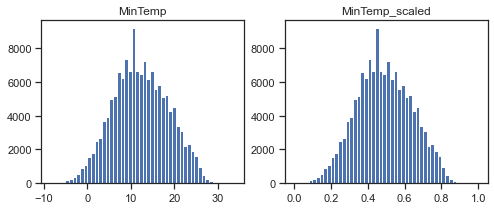

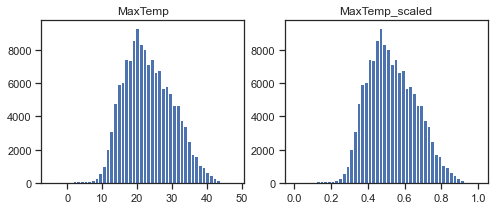

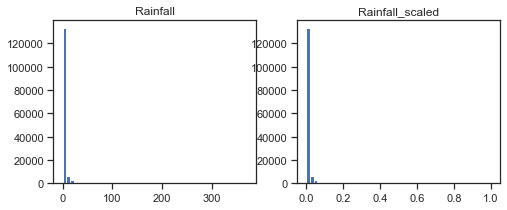

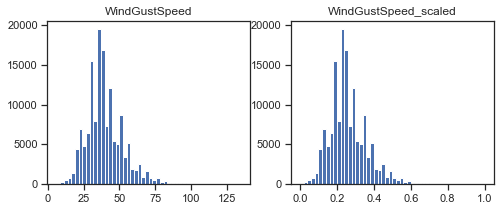

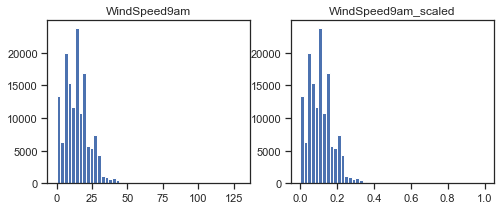

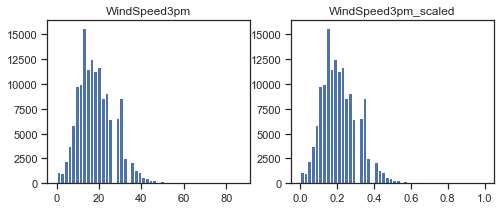

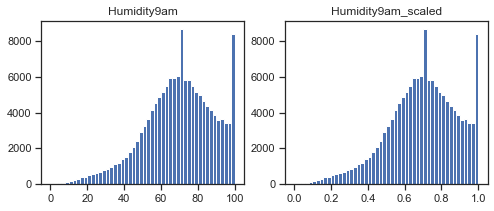

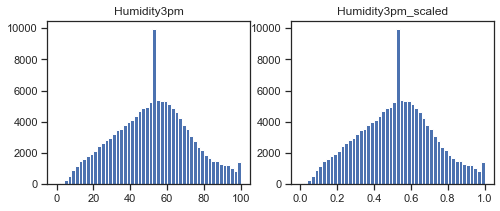

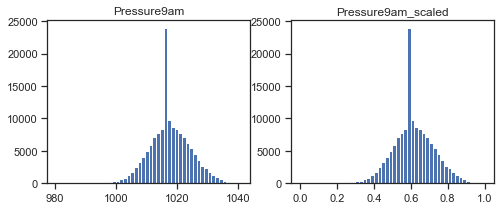

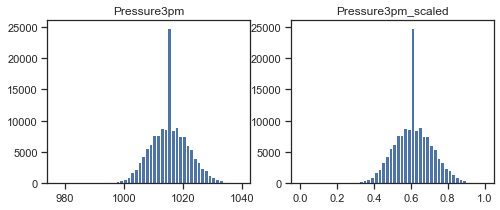

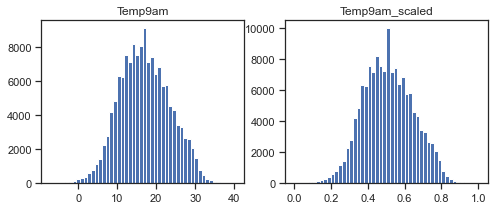

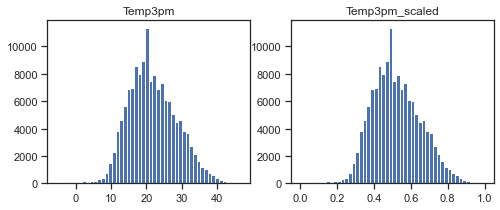

In [36]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

### Корреляционный анализ

In [37]:
# Немасштабированные признаки
corr_cols_1 = scale_cols + ['RainToday'] + ['RainTomorrow']
corr_cols_1

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow']

In [38]:
# Отмасштабированные признаки
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['RainToday'] + ['RainTomorrow']
corr_cols_2

['MinTemp_scaled',
 'MaxTemp_scaled',
 'Rainfall_scaled',
 'WindGustSpeed_scaled',
 'WindSpeed9am_scaled',
 'WindSpeed3pm_scaled',
 'Humidity9am_scaled',
 'Humidity3pm_scaled',
 'Pressure9am_scaled',
 'Pressure3pm_scaled',
 'Temp9am_scaled',
 'Temp3pm_scaled',
 'RainToday',
 'RainTomorrow']

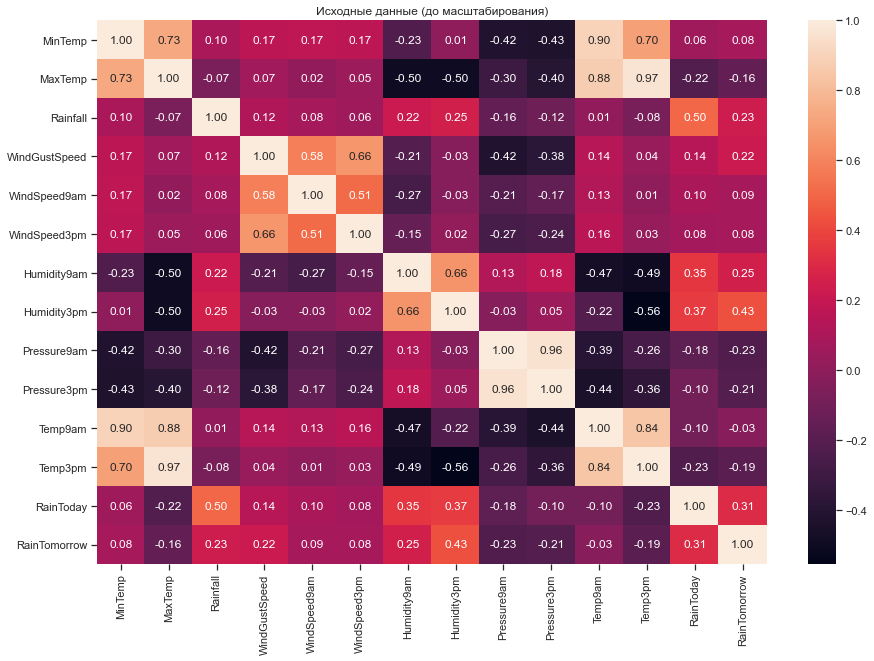

In [39]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data[corr_cols_1].corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

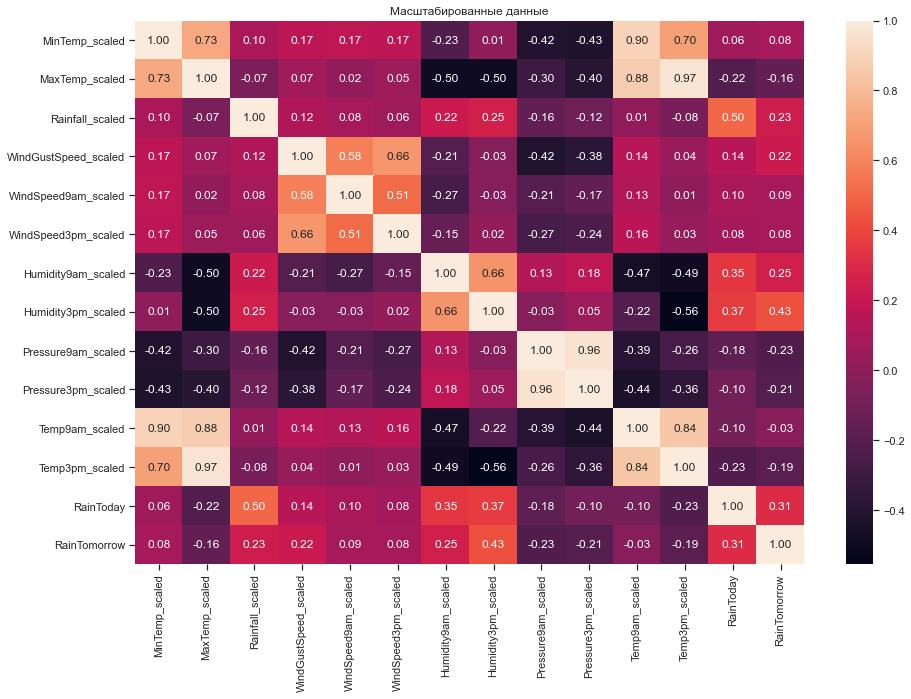

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data[corr_cols_2].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

- корреляционные матрицы для исходных и масштабированных данных совпадают;
- с целевым признаком больше всех коррелируют Rainfall, WindGustSpeed, Humidity9am, Humidity3pm, RainToday.

### Выбор метрик для последующей оценки качества моделей

Т.к. в данном примере решается задача бинарной классификации будем использовать следующие 4 метрики, формируемые на основе матрицы ошибок:
- precision - доля верно предсказанных классификатором положительных объектов (TP), из всех объектов, которые классификатор верно или неверно определил как положительные (TP+FP);
- recall - доля верно предсказанных классификатором положительных объектов (TP), из всех действительно положительных объектов (TP+FN);
- F1-мера - объединение precision и recall в единую метрику с весом точности 1;
- ROC AUC - основана на вычислении характеристик: TRP (recall, по y) и FPR (доля из объектов отрицательного класса (TN+FP), предсказанная неверно (FP), по х). Идеальная ROC-кривая проходит через верхний левый угол графика. Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации. В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

### Сохранение и визуализация метрик

In [41]:
# Класс, сохраняющий метрики качества построенных моделей, реализующий визуализацию метрик качества
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.3, a-0.1, str(round(b,3)), color='white')
        plt.show()  

### Выбор наиболее подходящих моделей для решения задачи классификации

Для задачи классификации будем использовать следующие модели:

- Логистическая регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

### Разделение выборки на обучающую и тестовую

In [42]:
X = data[['Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'RainToday']]
Y = data['RainTomorrow']

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [44]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((101822, 5), (43638, 5), (101822,), (43638,))

### Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров

In [69]:
#'SVC':SVC(probability=True),
# Модели
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

In [99]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [100]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    #plt.figure()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

In [101]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(X_train, Y_train)
    # Предсказание значений
    Y_pred = model.predict(X_test)
    # Предсказание вероятности класса "1" для roc auc
    Y_pred_proba_temp = model.predict_proba(X_test)
    Y_pred_proba = Y_pred_proba_temp[:,1]
    
    precision = precision_score(Y_test.values, Y_pred)
    recall = recall_score(Y_test.values, Y_pred)
    f1 = f1_score(Y_test.values, Y_pred)
    roc_auc = roc_auc_score(Y_test.values, Y_pred_proba)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    fig, ax = plt.subplots(ncols=2, figsize=(10,5))    
    draw_roc_curve(Y_test.values, Y_pred_proba, ax[0])
    plot_confusion_matrix(model, X_test, Y_test.values, ax=ax[1],
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    fig.suptitle(model_name)
    plt.show()

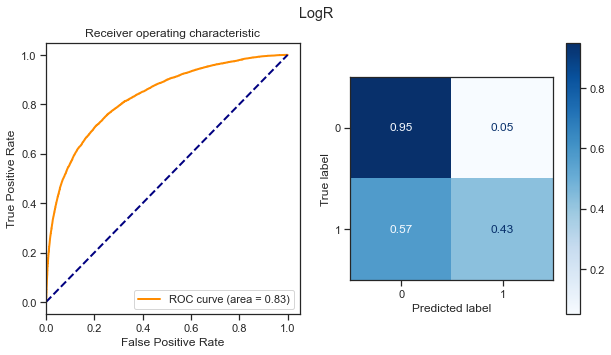

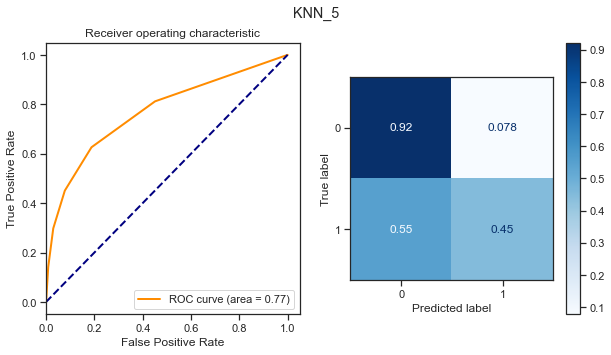

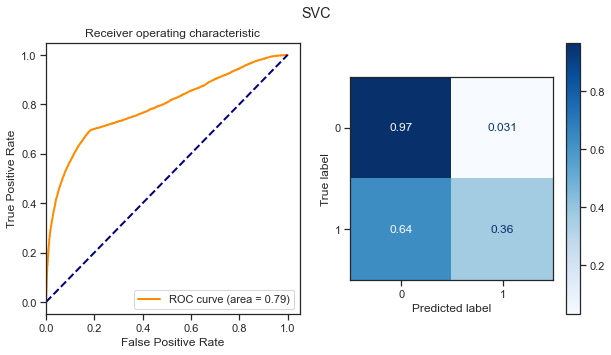

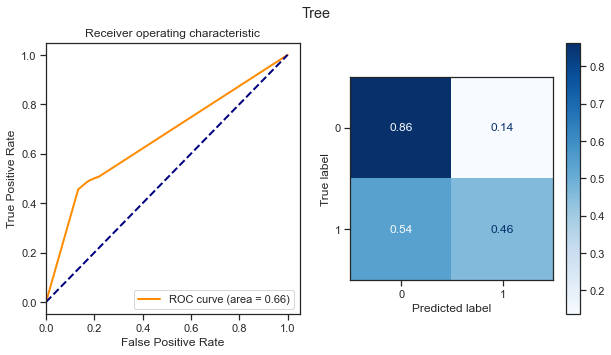

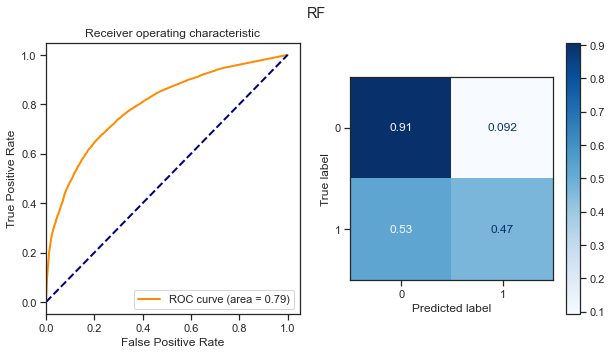

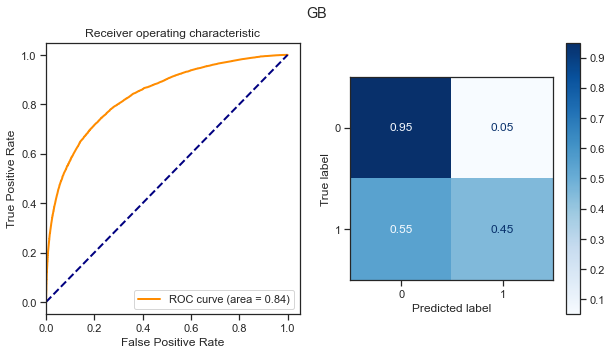

In [45]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

### Подбор гиперпараметров для выбранных моделей

- Logistic Regression

In [76]:
params = {'C': np.logspace(-2, 2, 40)}

In [77]:
grid_log = GridSearchCV(LogisticRegression(max_iter=30000), params, cv = 5, scoring = 'roc_auc')

In [78]:
grid_log.fit(X_train.head(25000), Y_train.head(25000))

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=30000),
             param_grid={'C': array([1.00000000e-02, 1.26638017e-02, 1.60371874e-02, 2.03091762e-02,
       2.57191381e-02, 3.25702066e-02, 4.12462638e-02, 5.22334507e-02,
       6.61474064e-02, 8.37677640e-02, 1.06081836e-01, 1.34339933e-01,
       1.70125428e-01, 2.15443469e-01, 2.72833338e-01, 3.45510729e-01,
       4.37547938e-01, 5.5410203....01703829e-01, 8.88623816e-01,
       1.12533558e+00, 1.42510267e+00, 1.80472177e+00, 2.28546386e+00,
       2.89426612e+00, 3.66524124e+00, 4.64158883e+00, 5.87801607e+00,
       7.44380301e+00, 9.42668455e+00, 1.19377664e+01, 1.51177507e+01,
       1.91448198e+01, 2.42446202e+01, 3.07029063e+01, 3.88815518e+01,
       4.92388263e+01, 6.23550734e+01, 7.89652287e+01, 1.00000000e+02])},
             scoring='roc_auc')

In [79]:
grid_log.best_params_, grid_log.best_score_

({'C': 0.0160371874375133}, 0.8295549650349651)

- Knn

In [80]:
param_knn = range(100,500,25)

In [81]:
n_range = np.array(param_knn)
tuned_params = [{'n_neighbors': n_range}]
tuned_params

[{'n_neighbors': array([100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400,
         425, 450, 475])}]

In [82]:
grid_knn = GridSearchCV(KNeighborsClassifier(), tuned_params, cv = StratifiedKFold(n_splits=5), 
                        scoring = 'roc_auc')
grid_knn.fit(X_train.head(25000), Y_train.head(25000))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400,
       425, 450, 475])}],
             scoring='roc_auc')

In [83]:
grid_knn.best_params_, grid_knn.best_score_

({'n_neighbors': 300}, 0.8307534965034966)

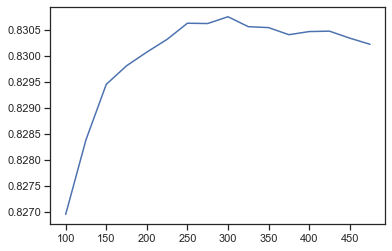

In [84]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, grid_knn.cv_results_['mean_test_score'])

- SVC

In [55]:
param_svc = [{'kernel':['linear'], 'C': [1,10,100]},
            {'kernel':['rbf'],'gamma': [0.01,0.1,1],'C':[1,10,100]}
            ]

In [56]:
grid_svc = RandomizedSearchCV(SVC(probability=True), param_svc, cv=5, scoring = 'roc_auc')
grid_svc.fit(X_train.head(5000), Y_train.head(5000))

RandomizedSearchCV(cv=5, estimator=SVC(probability=True),
                   param_distributions=[{'C': [1, 10, 100],
                                         'kernel': ['linear']},
                                        {'C': [1, 10, 100],
                                         'gamma': [0.01, 0.1, 1],
                                         'kernel': ['rbf']}],
                   scoring='roc_auc')

In [57]:
grid_svc.best_params_, grid_svc.best_score_

({'kernel': 'linear', 'C': 10}, 0.8219337150333293)

- Decision Tree

In [88]:
param_dt = [{'max_depth': range(1,10),
             'min_samples_split': [2,5,7,10],
             'min_samples_leaf': range(1,5),
             'max_features': range(1,5)
            }]

In [89]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_dt, cv=StratifiedKFold(n_splits=5), scoring = 'roc_auc')
grid_dt.fit(X_train.head(25000), Y_train.head(25000))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': range(1, 10),
                          'max_features': range(1, 5),
                          'min_samples_leaf': range(1, 5),
                          'min_samples_split': [2, 5, 7, 10]}],
             scoring='roc_auc')

In [90]:
grid_dt.best_params_, grid_dt.best_score_

({'max_depth': 6,
  'max_features': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 10},
 0.8208996037296037)

- Random Forest

In [94]:
param_rf = [{'max_depth': range(1,10),
             'min_samples_split': [2, 5, 10],
             'max_features': range(1,5)
            }]

In [95]:
grid_rf = RandomizedSearchCV(RandomForestClassifier(), param_rf, cv=5, scoring = 'roc_auc')
grid_rf.fit(X_train.head(10000), Y_train.head(10000))

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions=[{'max_depth': range(1, 10),
                                         'max_features': range(1, 5),
                                         'min_samples_split': [2, 5, 10]}],
                   scoring='roc_auc')

In [96]:
grid_rf.best_params_, grid_rf.best_score_

({'min_samples_split': 5, 'max_features': 3, 'max_depth': 7},
 0.8285119722637411)

- Gradient Boosting

In [62]:
param_gb = [{'n_estimators': range(5,200,25),
            'max_features': range(1,5)}]

In [63]:
grid_gb = GridSearchCV(GradientBoostingClassifier(), param_gb, cv=StratifiedKFold(n_splits=5), scoring = 'roc_auc')
grid_gb.fit(X_train.head(20000), Y_train.head(20000))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(),
             param_grid=[{'max_features': range(1, 5),
                          'n_estimators': range(5, 200, 25)}],
             scoring='roc_auc')

In [64]:
grid_gb.best_params_, grid_gb.best_score_

({'max_features': 4, 'n_estimators': 105}, 0.8301238142942573)

- LightGBM

In [51]:
d_train = lgb.LGBMClassifier()

In [66]:
lgbm_params = {'learning_rate': [0.01, 0.05, 0.001],
              'boosting_type': ['dart', 'gbdt'],
               'objective': ['binary'],
              'metric': ['auc'],
               'num_leaves': [50, 70,100,150],
              'max_depth': [5,6,7,8]}

In [67]:
grid_lgb = RandomizedSearchCV(d_train, lgbm_params, verbose=1,n_jobs=-1, cv = 10, scoring = 'roc_auc')
grid_lgb.fit(X_train.head(10000), Y_train.head(10000))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'boosting_type': ['dart', 'gbdt'],
                                        'learning_rate': [0.01, 0.05, 0.001],
                                        'max_depth': [5, 6, 7, 8],
                                        'metric': ['auc'],
                                        'num_leaves': [50, 70, 100, 150],
                                        'objective': ['binary']},
                   scoring='roc_auc', verbose=1)

In [68]:
grid_lgb.best_params_, grid_lgb.best_score_

({'objective': 'binary',
  'num_leaves': 50,
  'metric': 'auc',
  'max_depth': 5,
  'learning_rate': 0.05,
  'boosting_type': 'dart'},
 0.8302775386778682)

In [97]:
# 'SVC':SVC(probability=True),
# 'SVC_grid': grid_svc.best_estimator_,
clas_models_grid = {'LogR': LogisticRegression(), 
                    'LogR_grid': grid_log.best_estimator_,
                    'KNN_5':KNeighborsClassifier(n_neighbors=5),
                    'KNN_grid': grid_knn.best_estimator_,

                    'Tree':DecisionTreeClassifier(),
                    'Tree_grid': grid_dt.best_estimator_,
                    'RF':RandomForestClassifier(),
                    'RF_grid': grid_rf.best_estimator_,
                    'GB':GradientBoostingClassifier(),
                    'GB_grid': grid_lgb.best_estimator_}

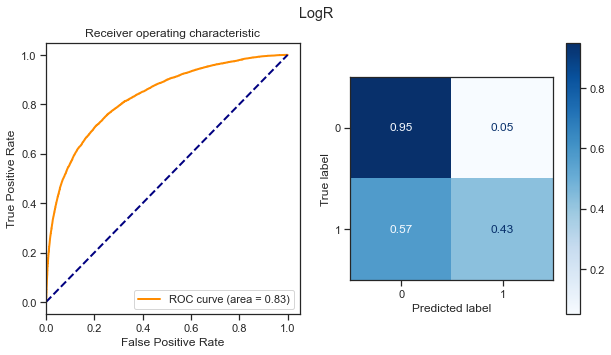

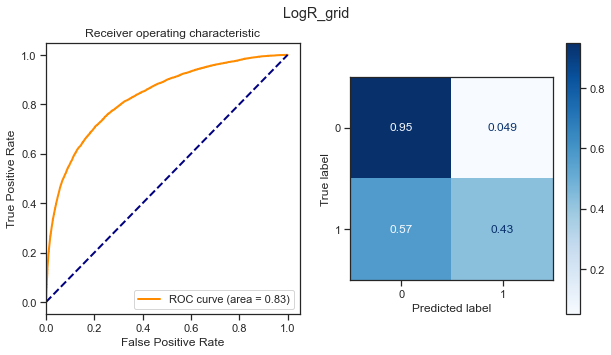

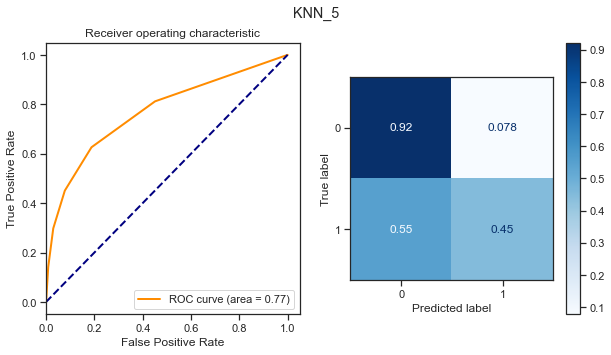

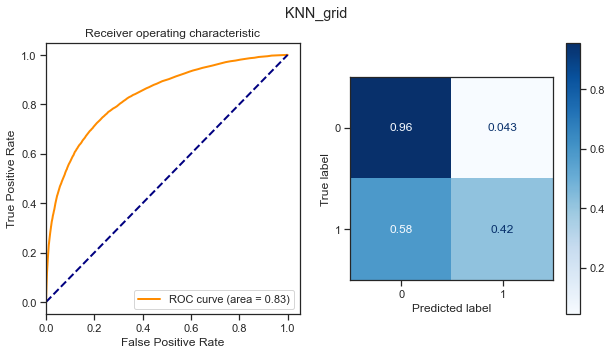

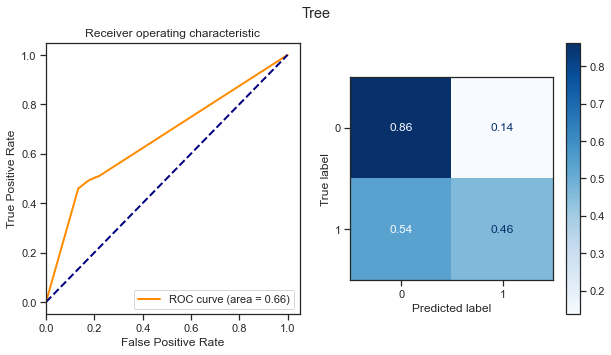

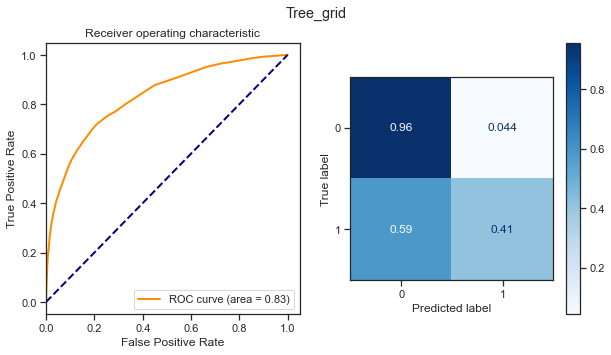

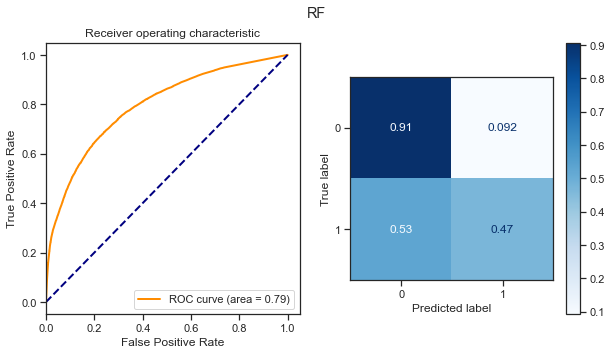

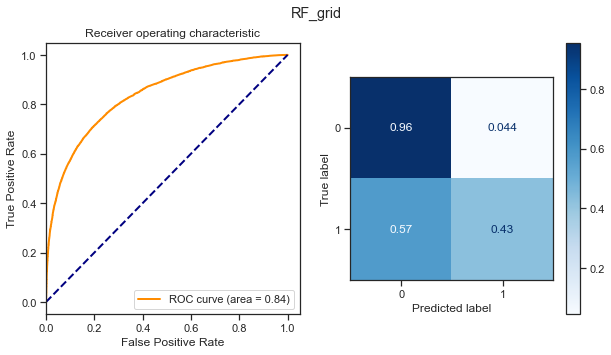

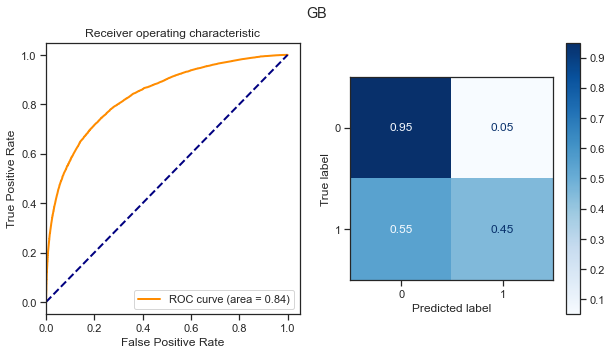

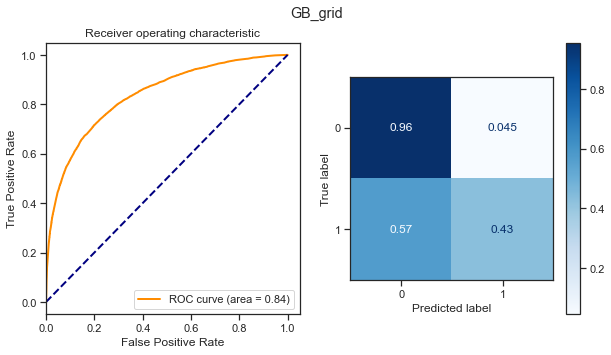

In [102]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

### Формирование выводов о качестве построенных моделей на основе выбранных метрик

In [103]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

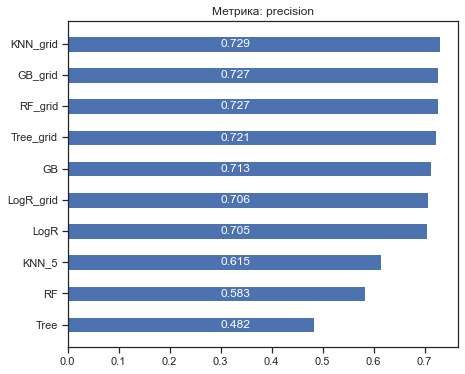

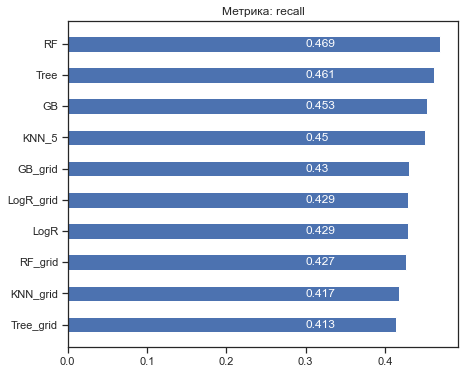

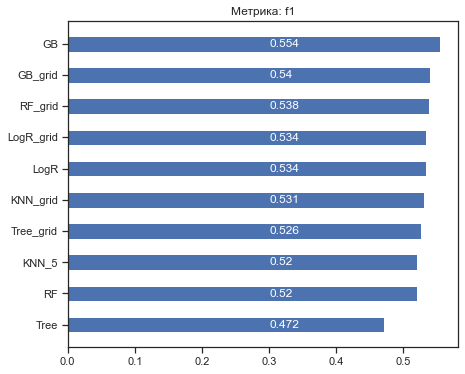

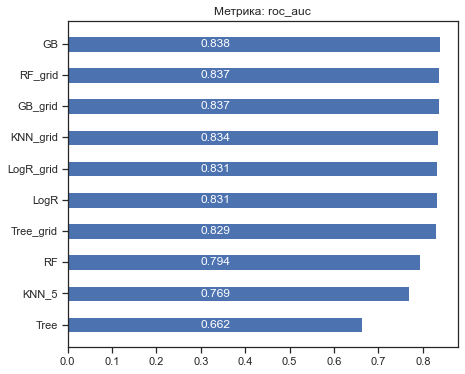

In [104]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

### Вывод

На основании двух используемых метрик из четырех лучшей моделью оказался градиентный бустинг.

### АutoML

In [4]:
df = pd.read_csv("weatherAUS.csv", skipinitialspace=True,)
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df["RainTomorrow"], test_size=0.25)

automl = AutoML(mode = 'Perform',
                results_path="AutoML_classi",
               eval_metric = 'auc')
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)

There are samples with missing target values in the data which will be excluded for further analysis


Linear algorithm was disabled.
AutoML directory: AutoML_classi
The task is binary_classification with evaluation metric auc
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM auc 0.895487 trained in 824.44 seconds (1-sample predict time 0.1269 seconds)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


2_Default_Xgboost auc 0.895393 trained in 203.59 seconds (1-sample predict time 0.1368 seconds)
3_Default_CatBoost auc 0.917828 trained in 788.42 seconds (1-sample predict time 0.0695 seconds)
* Step not_so_random will try to check up to 20 models
8_LightGBM auc 0.89532 trained in 619.92 seconds (1-sample predict time 0.1399 seconds)
* Step golden_features will try to check up to 1 model
None 10
Add Golden Feature: Humidity3pm_diff_Pressure9am
Add Golden Feature: Humidity3pm_sum_WindGustSpeed
Add Golden Feature: Sunshine_diff_Humidity3pm
Add Golden Feature: Cloud3pm_sum_Humidity3pm
Add Golden Feature: Cloud9am_sum_Humidity3pm
Add Golden Feature: Humidity3pm_multiply_WindGustSpeed
Add Golden Feature: Cloud3pm_multiply_Humidity3pm
Add Golden Feature: Humidity3pm_sum_MinTemp
Add Golden Feature: Humidity3pm_sum_Evaporation
Add Golden Feature: Humidity3pm_sum_WindSpeed9am
Created 10 Golden Features in 10.34 seconds.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


2_Default_Xgboost_GoldenFeatures auc 0.894359 trained in 211.26 seconds (1-sample predict time 0.1714 seconds)
Not enough time to perform features selection. Skip
Time needed for features selection ~ 410.0 seconds
Please increase total_time_limit to at least (4157 seconds) to have features selection
Skip insert_random_feature because no parameters were generated.
Skip features_selection because no parameters were generated.
* Step hill_climbing_1 will try to check up to 7 models
9_CatBoost auc 0.917127 trained in 577.97 seconds (1-sample predict time 0.0698 seconds)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


11_Xgboost auc 0.894851 trained in 199.49 seconds (1-sample predict time 0.1575 seconds)
* Step hill_climbing_2 will try to check up to 8 models
* Step ensemble will try to check up to 1 model
Ensemble auc 0.918512 trained in 23.08 seconds (1-sample predict time 0.1711 seconds)
AutoML fit time: 3469.72 seconds
AutoML best model: Ensemble


In [109]:
df = pd.read_csv("weatherAUS.csv", skipinitialspace=True,)
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df["RainTomorrow"], test_size=0.25)

automl = AutoML(mode = 'Explain',
                algorithms=[ "Random Forest",'Nearest Neighbors',
                            "Decision Tree","LightGBM", 'Neural Network'],
                results_path="AutoML_classific",
                explain_level=1,
               eval_metric = 'auc')
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)

There are samples with missing target values in the data which will be excluded for further analysis


Linear algorithm was disabled.
AutoML directory: AutoML_classific
The task is binary_classification with evaluation metric auc
AutoML will use algorithms: ['Random Forest', 'Nearest Neighbors', 'Decision Tree', 'LightGBM', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_DecisionTree auc 0.793345 trained in 19.45 seconds
* Step default_algorithms will try to check up to 3 models
2_Default_LightGBM auc 0.89094 trained in 150.46 seconds
3_Default_NeuralNetwork auc 0.871948 trained in 25.1 seconds
4_Default_RandomForest auc 0.836404 trained in 14.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble auc 0.89094 trained in 5.2 seconds
AutoML fit time: 221.21 seconds
AutoML best model: 2_Default_LightGBM


automl.report()